# Acoustic Event Detection Challenge assignment

### Research Question

* Main research question:

 * Can we infer the source of a sound recording from the tract and E (dB) data?

* Subquestions:

 *  How can we, based on the tract and E data, define a suitable set of features?
 *  Which algorithms can be used to solve this task?
 *  How does performance of the classifiers built depend on the machine learning algorithm and their parameters?
 *  How does performance of the classifiers built depend on feature extraction parameters?



The features must represent the sound in some way, and I think vertical peak (change in pulse) and horizantal peak (change in tone) are good features to represent sound because they don't contain time information. For example we have two dog bark sounds, one happend at the 1 second, and the other one happed at 3 second, they will appear quite different for machines. So I need to have some **time irrelevant** features feed to machine for machine learning. ERON: I guess you mean **time invariant** ;-)

In [1]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn import svm
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import KFold    #  For cross validation
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# Packages for visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Allows charts to appear in the notebook
%matplotlib inline

# Pickle package
import pickle

In [2]:
#read all the esc50 files (2000 files), and drop the 'fold','esc10','src_file','take' columns which has nothing useful for classifier
esc50 = pd.read_csv('/home/meitao/Desktop/ESC-50/meta/esc50.csv').drop(['fold','esc10','src_file','take'],axis=1)

In [3]:
# show what my data now looks like
esc50

,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,14,chirping_birds
2,1-100210-A-36.wav,36,vacuum_cleaner
3,1-100210-B-36.wav,36,vacuum_cleaner
4,1-101296-A-19.wav,19,thunderstorm
...,...,...,...
1995,5-263831-B-6.wav,6,hen
1996,5-263902-A-36.wav,36,vacuum_cleaner
1997,5-51149-A-25.wav,25,footsteps
1998,5-61635-A-8.wav,8,sheep


* One of the hints of the assignment is to build my own features on the tract and EdB data, so I make some functions to exctract features.
  * what I do is squeeze Edb and s_tract, f_tract to a compact one (from 100* 8500 to 10* 100 or from 88* 8500 to 10* 100)
  * Because the compact E and s_tract, f_tract features also contain time information, I calculate the max min and mean for each row (you can think calculate these features for a frequency band because it's a compact version of E and tract files).
  * At the lower part of this assignment I make **"standard diveation of histogram"** features and **"frequency proportion"** features.

In [4]:
# function: use filename(***.wav) to extract features and append to the csv
scaler = MinMaxScaler()

###############################################################
# function to get my E feature (like E in the PTNE)
def E_feature(filename):
    sum_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    E = np.asarray(file['E'])# save as np array
    
    # There are some noise in the data, so before I use MinMaxScale() I need to delete some values which is too big 
    # that they will make other values very small when scaling
    E=np.where(E>np.percentile(E,noise_cancel),np.percentile(E,noise_cancel),E)
    
    E = scaler.fit_transform(E) # scale the data from 0 to 1
    
    m,n = E.shape  #100 8500----> 10,100
    #print(m,n)
    ###########################################################################################################
    # make a new a (similar) E feature, with shape of 10*100 (each point is the sum of a square(10*85))    ####
    ###########################################################################################################
    for i in range(10):   
        for j in range(99):
            a=np.sum(E[0+10*i:10+10*i, 0+85*j:85+85*j]) # sum of a square (10*85)
            sum_list.append(a)
        a=np.sum(E[0+10*i:10+10*i,8415:])  # because some file is not 8500 columns
        sum_list.append(a)
    feature_array=np.asarray(sum_list).reshape(10,100)  # get a new feature array like PTNE, but with better resolution
    log_feature_array=np.log(feature_array)   # Log 10 to the element of this array
    
    ######    plot test code: just to check my own feature
    #plt.figure(figsize=(20, 4))
    #plt.imshow(log_feature_array,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    #s_tract_max=np.max(feature_array[0])+np.max(feature_array[1])+np.max(feature_array[2])+np.max(feature_array[3])+np.max(feature_array[4])+np.max(feature_array[5])+np.max(feature_array[6])+np.max(feature_array[7])
    return log_feature_array




def s_tract_feature(filename):
    sum_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    s_tract = np.asarray(file['s_tract'])# save as np array

    #  delete first and last 6 rows
    s_tract=np.delete(s_tract, np.s_[0:6:1], 0)
    s_tract=np.delete(s_tract, np.s_[88:94:1], 0)  ##  88 rows now
    
    s_tract=np.where(s_tract>np.percentile(s_tract,noise_cancel),np.percentile(s_tract,noise_cancel),s_tract)
    
    s_tract = scaler.fit_transform(s_tract) # scale the data from 0 to 1
    
    m,n = s_tract.shape  #100  about8500----> 10,100
    #print(m,n)
    #####################################################################
    # make a s_tract feature, with shape of 10*100    ####
    #####################################################################
    for i in range(9):   
        for j in range(99):
            a=np.sum(s_tract[0+9*i:9+9*i, 0+85*j:85+85*j]) # A square of 9*85
            sum_list.append(a)
        a=np.sum(s_tract[0+9*i:9+9*i,8415:])  # because some file is not 8500 columns
        sum_list.append(a)
    for k in range(99):
        a=np.sum(s_tract[81:88, 0+85*k:85+85*k])
        sum_list.append(a)
    a=np.sum(s_tract[81:88,8415:])  # because some file is not 8500 columns
    sum_list.append(a)
    
    feature_array=np.asarray(sum_list).reshape(10,100)  # get a new feature array like PTNE, but with better resolution
    #log_feature_array=np.log(feature_array)   # Log 10 to the element of this array
    
    ######    plot test code: just to check my own feature
    #plt.figure(figsize=(20, 4))
    #plt.imshow(feature_array,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    #s_tract_max=np.max(feature_array[0])+np.max(feature_array[1])+np.max(feature_array[2])+np.max(feature_array[3])+np.max(feature_array[4])+np.max(feature_array[5])+np.max(feature_array[6])+np.max(feature_array[7])
    return feature_array





def f_tract_feature(filename):
    sum_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    f_tract = np.asarray(file['f_tract'])# save as np array

    #  delete first and last 6 rows
    f_tract=np.delete(f_tract, np.s_[0:6:1], 0)
    f_tract=np.delete(f_tract, np.s_[88:94:1], 0)  ##  88 rows now
    
    f_tract=np.where(f_tract>np.percentile(f_tract,noise_cancel),np.percentile(f_tract,noise_cancel),f_tract)
    
    f_tract = scaler.fit_transform(f_tract) # scale the data from 0 to 1
    
    m,n = f_tract.shape  #100  about8500----> 10,100
    #print(m,n)
    #####################################################################
    # make a s_tract feature, with shape of 10*100    ####
    #####################################################################
    for i in range(9):   
        for j in range(99):
            a=np.sum(f_tract[0+9*i:9+9*i, 0+85*j:85+85*j])
            sum_list.append(a)
        a=np.sum(f_tract[0+9*i:9+9*i,8415:])  # because some file is not 8500 columns
        sum_list.append(a)
    for k in range(99):
        a=np.sum(f_tract[81:88, 0+85*k:85+85*k])
        sum_list.append(a)
    a=np.sum(f_tract[81:88,8415:])  # because some file is not 8500 columns
    sum_list.append(a)
    
    feature_array=np.asarray(sum_list).reshape(10,100)  # get a new feature array like PTNE, but with better resolution
    #log_feature_array=np.log(feature_array)   # Log 10 to the element of this array
    
    ######    plot test code: just to check my own feature
    #plt.figure(figsize=(20, 4))
    #plt.imshow(feature_array,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    #s_tract_max=np.max(feature_array[0])+np.max(feature_array[1])+np.max(feature_array[2])+np.max(feature_array[3])+np.max(feature_array[4])+np.max(feature_array[5])+np.max(feature_array[6])+np.max(feature_array[7])
    return feature_array



In [5]:
#########  functions to get max min mean features of a given array
def max_feature(array):
    m,n = array.shape
    compress_array = np.amax(array,axis=1)
    sum_=np.sum(compress_array)
    return sum_
def min_feature(array):
    m,n = array.shape
    compress_array = np.amin(array,axis=1)
    sum_=np.sum(compress_array)
    return sum_
def mean_feature(array):
    m,n = array.shape
    compress_array = np.mean(array,axis=1)
    sum_=np.sum(compress_array)
    return sum_

* Next step I will append these features to every file, and make a new CSV file

I put all the file name into a list "filelist".

In [6]:
filelist=[]
for index, row in esc50.iterrows():        ###############     esc50_test    ##############
    #using functions to get the feature values and store them in the list
    filename=row['filename']
    filelist.append(filename)

I make sevaral empty list to store features

In [7]:
E_max=[]
E_min=[]
E_mean=[]

s_tract_max=[]
s_tract_min=[]
s_tract_mean=[]

f_tract_max=[]
f_tract_min=[]
f_tract_mean=[]

Then I extract features and put them into lists

In [8]:
for file in filelist:
    E_max.append(max_feature(E_feature(file)))
    E_min.append(min_feature(E_feature(file)))
    E_mean.append(mean_feature(E_feature(file)))
    
    s_tract_max.append(max_feature(s_tract_feature(file)))
    s_tract_min.append(min_feature(s_tract_feature(file)))
    s_tract_mean.append(mean_feature(s_tract_feature(file)))
    
    f_tract_max.append(max_feature(f_tract_feature(file)))
    f_tract_min.append(min_feature(f_tract_feature(file)))
    f_tract_mean.append(mean_feature(f_tract_feature(file)))
# delete print later    
#print(E_max)


/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/home/meitao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero enc

In [9]:
# put the features columns behind the original CSV
esc50['E_max']=E_max
esc50['E_min']=E_min
esc50['E_mean']=E_mean

esc50['s_tract_max']=s_tract_max
esc50['s_tract_min']=s_tract_min
esc50['s_tract_mean']=s_tract_mean

esc50['f_tract_max']=f_tract_max
esc50['f_tract_min']=f_tract_min
esc50['f_tract_mean']=f_tract_mean

In [10]:
esc50.head()

,filename,target,category,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean
0,1-100032-A-0.wav,0,dog,67.166725,29.343847,37.241173,6485.417969,1740.928955,4004.900391,6001.519043,2003.270020,3962.887207
1,1-100038-A-14.wav,14,chirping_birds,36.617298,10.730089,23.061266,6656.100098,1465.533691,3899.509033,6055.021484,1713.974731,4057.520996
2,1-100210-A-36.wav,36,vacuum_cleaner,55.292480,36.739639,48.365402,6453.810547,1688.325806,3961.674805,6184.546387,2020.870239,4006.621094
3,1-100210-B-36.wav,36,vacuum_cleaner,55.750061,31.975002,48.223885,6673.046875,1628.578735,3958.976807,6106.848633,1871.696289,3974.582764
4,1-101296-A-19.wav,19,thunderstorm,58.286949,34.062756,45.624672,6503.320801,1620.544189,4021.025879,6120.110840,1999.911255,3993.894287


In [11]:
esc50.describe() 

,target,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,24.500000,59.530433,-inf,-inf,6484.048045,1514.623037,3922.113155,6222.766781,1736.329498,3943.369602
std,14.434479,7.717816,NaN,NaN,289.793518,228.603888,178.819729,205.103284,356.496508,119.175795
min,0.000000,-22.511301,-inf,-inf,3817.737061,0.000000,2672.686523,4840.597168,0.000000,3276.931152
25%,12.000000,57.150253,9.161623,36.126199,6397.183228,1412.334564,3878.040710,6095.605469,1604.185150,3912.156006
50%,24.500000,61.440231,20.895304,41.715553,6509.396240,1545.883423,3957.942627,6203.013916,1837.816467,3958.583740
75%,37.000000,64.226900,31.396547,47.070189,6632.806274,1642.119781,4008.721008,6338.607544,1961.923218,3995.720947
max,49.000000,67.342873,54.995777,57.393692,7210.604492,2981.968506,4943.807129,7024.095703,2881.730713,4660.621582


* I also build some features using histograms:

In [12]:
#########   build s_tract histogram array
def s_tract_hist(filename):    
    s_tract_hist_features_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    s_tract = np.asarray(file['s_tract'])# save as np array
    s_tract=np.delete(s_tract, np.s_[0:6:1], 0)
    s_tract=np.delete(s_tract, np.s_[88:94:1], 0)
        
    # delete noises ( delete top 10% value)
    s_tract=np.where(s_tract>np.percentile(s_tract,noise_cancel),np.percentile(s_tract,noise_cancel),s_tract)
    # transform the data to a range of 0 ot 1
    
    scaler = MinMaxScaler()
    s_tract = scaler.fit_transform(s_tract)
        
    #s_tract=np.nan_to_num(s_tract, nan=0,posinf=0, neginf=0)  #   NAN posINF negINF
        
    s_tract=np.sum(s_tract,axis=1)  # get the sum of every rows
    s_tract=np.reshape(s_tract,(88,1)) 

        
    ##############################################
    ##  parameters that can be changed later!!!###
    ##############################################
    low_boundray=0
    high_boundray=8000
    bin_width=100
        
    s_hist_bins=np.arange(low_boundray,high_boundray+bin_width,bin_width)
        
        ####################  Plot to choose the right low_boundray,high_boundray and bin_width  
        #plt.hist(s_tract,bins=s_hist_bins,rwidth=0.8)
        #plt.xlim(0,8000)
        #plt.ylim(0,30)
        #plt.show()
        
    s_hist,s_bins=np.histogram(s_tract, bins=s_hist_bins)
    s_tract_hist_features_list.append(s_hist)
    return s_tract_hist_features_list




#########   build f_tract histogram array
def f_tract_hist(filename):    
    f_tract_hist_features_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    f_tract = np.asarray(file['f_tract'])# save as np array
    f_tract=np.delete(f_tract, np.s_[0:6:1], 0)
    f_tract=np.delete(f_tract, np.s_[88:94:1], 0)
        
    # delete noises ( make top 10% value to 90%)
    f_tract=np.where(f_tract>np.percentile(f_tract,noise_cancel),np.percentile(f_tract,noise_cancel),f_tract)
    # transform the data to a range of 0 ot 1
    
    scaler = MinMaxScaler()
    f_tract = scaler.fit_transform(f_tract)
        
    #s_tract=np.nan_to_num(s_tract, nan=0,posinf=0, neginf=0)  #   NAN posINF negINF
        
    f_tract=np.sum(f_tract,axis=1)
    f_tract=np.reshape(f_tract,(88,1)) 

        
        ##############################################
        ##  parameters that can be changed later!!!###
        ##############################################
    low_boundray=0
    high_boundray=8000
    bin_width=100
        
    f_hist_bins=np.arange(low_boundray,high_boundray+bin_width,bin_width)
        
        ####################  Plot to choose the right low_boundray,high_boundray and bin_width  
        #plt.hist(s_tract,bins=s_hist_bins,rwidth=0.8)
        #plt.xlim(0,8000)
        #plt.ylim(0,30)
        #plt.show()
        
    f_hist,f_bins=np.histogram(f_tract, bins=f_hist_bins)
    f_tract_hist_features_list.append(f_hist)
    return f_tract_hist_features_list

I calculated the standard deviation for s&f_tract histograms, and make them features.

In [13]:
s_tract_hist_list=[]
f_tract_hist_list=[]
for file in filelist:
    s_tract_hist_list.append(np.std(s_tract_hist(file)))
    f_tract_hist_list.append(np.std(f_tract_hist(file)))

In [14]:
esc50['s_tract_hist']=s_tract_hist_list
esc50['f_tract_hist']=f_tract_hist_list

In [15]:
esc50.head()

,filename,target,category,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean,s_tract_hist,f_tract_hist
0,1-100032-A-0.wav,0,dog,67.166725,29.343847,37.241173,6485.417969,1740.928955,4004.900391,6001.519043,2003.270020,3962.887207,3.455431,3.168596
1,1-100038-A-14.wav,14,chirping_birds,36.617298,10.730089,23.061266,6656.100098,1465.533691,3899.509033,6055.021484,1713.974731,4057.520996,2.672078,2.130728
2,1-100210-A-36.wav,36,vacuum_cleaner,55.292480,36.739639,48.365402,6453.810547,1688.325806,3961.674805,6184.546387,2020.870239,4006.621094,2.998333,2.643861
3,1-100210-B-36.wav,36,vacuum_cleaner,55.750061,31.975002,48.223885,6673.046875,1628.578735,3958.976807,6106.848633,1871.696289,3974.582764,2.913760,2.487971
4,1-101296-A-19.wav,19,thunderstorm,58.286949,34.062756,45.624672,6503.320801,1620.544189,4021.025879,6120.110840,1999.911255,3993.894287,3.455431,2.695366


Now I have 11 features for each file. I have to normalize these features if I want them to have the same weight for machine learning algorithm.

In [16]:
esc50['E_max']=scaler.fit_transform(np.asarray(esc50['E_max']).reshape(-1, 1))
esc50['E_min']=scaler.fit_transform(np.asarray(esc50['E_max']).reshape(-1, 1))
esc50['E_mean']=scaler.fit_transform(np.asarray(esc50['E_max']).reshape(-1, 1))

esc50['s_tract_max']=scaler.fit_transform(np.asarray(esc50['s_tract_max']).reshape(-1, 1))
esc50['s_tract_min']=scaler.fit_transform(np.asarray(esc50['s_tract_max']).reshape(-1, 1))
esc50['s_tract_mean']=scaler.fit_transform(np.asarray(esc50['s_tract_max']).reshape(-1, 1))

esc50['f_tract_max']=scaler.fit_transform(np.asarray(esc50['f_tract_max']).reshape(-1, 1))
esc50['f_tract_min']=scaler.fit_transform(np.asarray(esc50['f_tract_max']).reshape(-1, 1))
esc50['f_tract_mean']=scaler.fit_transform(np.asarray(esc50['f_tract_max']).reshape(-1, 1))

esc50['s_tract_hist']=scaler.fit_transform(np.asarray(esc50['s_tract_hist']).reshape(-1, 1))
esc50['f_tract_hist']=scaler.fit_transform(np.asarray(esc50['f_tract_hist']).reshape(-1, 1))

In [17]:
esc50.head()

,filename,target,category,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean,s_tract_hist,f_tract_hist
0,1-100032-A-0.wav,0,dog,0.998040,0.998040,0.998040,0.786261,0.786261,0.786261,0.531680,0.531680,0.531680,0.619892,0.552033
1,1-100038-A-14.wav,14,chirping_birds,0.658051,0.658051,0.658051,0.836568,0.836568,0.836568,0.556183,0.556183,0.556183,0.407828,0.270189
2,1-100210-A-36.wav,36,vacuum_cleaner,0.865889,0.865889,0.865889,0.776946,0.776946,0.776946,0.615503,0.615503,0.615503,0.496149,0.409536
3,1-100210-B-36.wav,36,vacuum_cleaner,0.870982,0.870982,0.870982,0.841562,0.841562,0.841562,0.579919,0.579919,0.579919,0.473254,0.367202
4,1-101296-A-19.wav,19,thunderstorm,0.899215,0.899215,0.899215,0.791538,0.791538,0.791538,0.585992,0.585992,0.585992,0.619892,0.423522


In [18]:
esc50.describe()

,target,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean,s_tract_hist,f_tract_hist
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,24.500000,0.913054,0.913054,0.913054,0.785858,0.785858,0.785858,0.633007,0.633007,0.633007,0.464746,0.424409
std,14.434479,0.085893,0.085893,0.085893,0.085413,0.085413,0.085413,0.093933,0.093933,0.093933,0.188313,0.150116
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.886565,0.886565,0.886565,0.760256,0.760256,0.760256,0.574769,0.574769,0.574769,0.324513,0.319101
50%,24.500000,0.934309,0.934309,0.934309,0.793329,0.793329,0.793329,0.623960,0.623960,0.623960,0.463908,0.423522
75%,37.000000,0.965322,0.965322,0.965322,0.829702,0.829702,0.829702,0.686060,0.686060,0.686060,0.610294,0.527306
max,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now I have 11 features, and all the values for features are from 0 to 1.

In [19]:
esc50_features_array=np.asarray(esc50[['E_max','E_min','E_mean',
                                       's_tract_max','s_tract_min','s_tract_mean',
                                       'f_tract_max','f_tract_min','f_tract_mean',
                                      's_tract_hist','f_tract_hist']])
esc50_features_array.shape

(2000, 11)

I will plot the features to decide whether they are "good" features

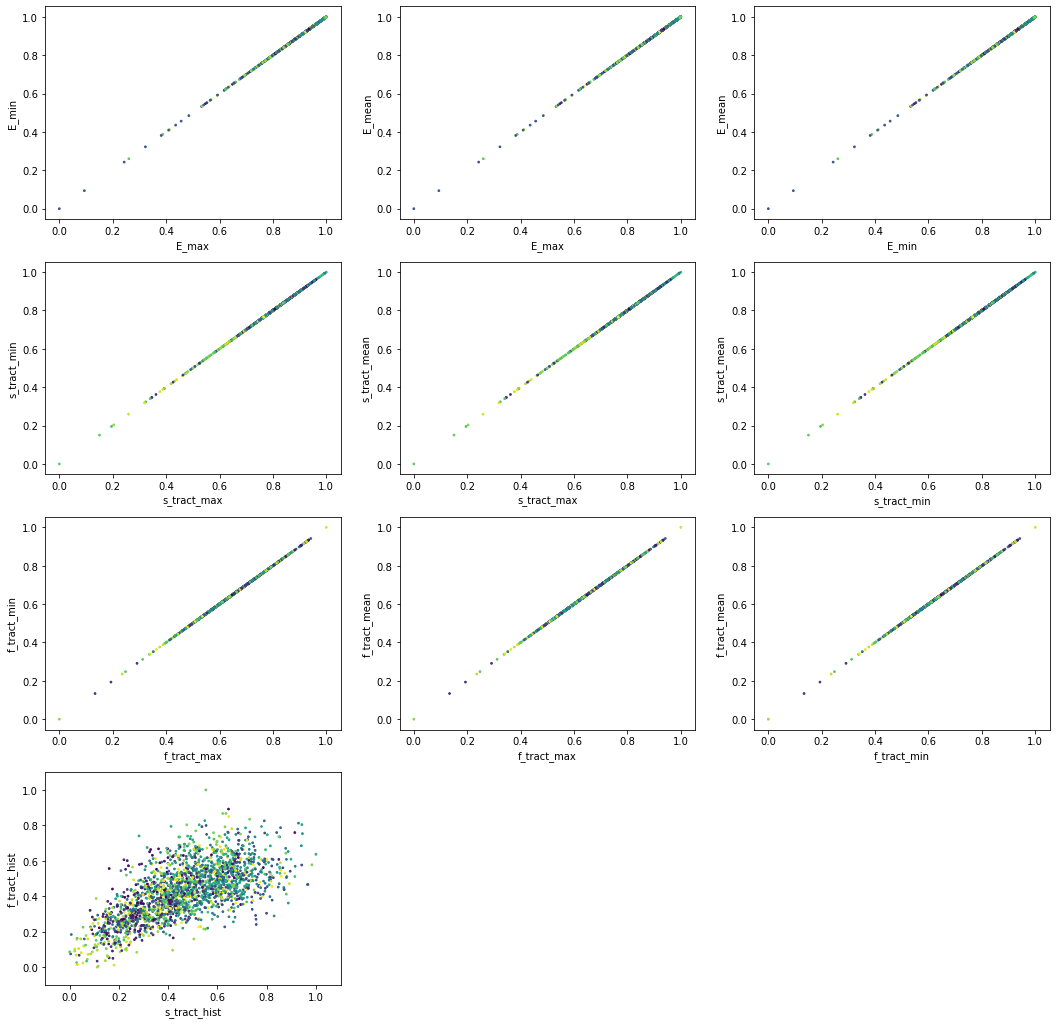

In [20]:
color = np.asarray(esc50['target'])

fig = plt.figure(figsize=(18, 18))
#########   E   ###########
plt.subplot(4,3,1)
plt.scatter(esc50['E_max'],esc50['E_min'],s=3,c=color)
plt.xlabel('E_max')
plt.ylabel('E_min')

plt.subplot(4,3,2)
plt.scatter(esc50['E_max'],esc50['E_mean'],s=3,c=color)
plt.xlabel('E_max')
plt.ylabel('E_mean')

plt.subplot(4,3,3)
plt.scatter(esc50['E_min'],esc50['E_mean'],s=3,c=color)
plt.xlabel('E_min')
plt.ylabel('E_mean')

#########   s_tract   ######
plt.subplot(4,3,4)
plt.scatter(esc50['s_tract_max'],esc50['s_tract_min'],s=3,c=color)
plt.xlabel('s_tract_max')
plt.ylabel('s_tract_min')

plt.subplot(4,3,5)
plt.scatter(esc50['s_tract_max'],esc50['s_tract_mean'],s=3,c=color)
plt.xlabel('s_tract_max')
plt.ylabel('s_tract_mean')

plt.subplot(4,3,6)
plt.scatter(esc50['s_tract_min'],esc50['s_tract_mean'],s=3,c=color)
plt.xlabel('s_tract_min')
plt.ylabel('s_tract_mean')

#########   f_tract   ######
plt.subplot(4,3,7)
plt.scatter(esc50['f_tract_max'],esc50['f_tract_min'],s=3,c=color)
plt.xlabel('f_tract_max')
plt.ylabel('f_tract_min')

plt.subplot(4,3,8)
plt.scatter(esc50['f_tract_max'],esc50['f_tract_mean'],s=3,c=color)
plt.xlabel('f_tract_max')
plt.ylabel('f_tract_mean')

plt.subplot(4,3,9)
plt.scatter(esc50['f_tract_min'],esc50['f_tract_mean'],s=3,c=color)
plt.xlabel('f_tract_min')
plt.ylabel('f_tract_mean')
            
#########   histogram features   ######
plt.subplot(4,3,10)
plt.scatter(esc50['s_tract_hist'],esc50['f_tract_hist'],s=3,c=color)
plt.xlabel('s_tract_hist')
plt.ylabel('f_tract_hist')

plt.subplots_adjust(hspace=0.2)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [21]:
esc50['f_tract_hist'].describe()

count    2000.000000
mean        0.424409
std         0.150116
min         0.000000
25%         0.319101
50%         0.423522
75%         0.527306
max         1.000000
Name: f_tract_hist, dtype: float64

From the feature comparison, we will not use the "E", "s_tract", "f_tract" features to separate the sounds, but the "s_tract_hist" and "s_tract_hist" features are some good features.

First I use just two features, and use KMeans to make clusters, just to see what I get.

In [22]:
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=50)
kmeans_2_cluster = kmeans_2.fit_predict(esc50[['s_tract_hist','f_tract_hist']])

In [23]:
from scipy.stats import mode
target=np.asarray(esc50['target'])
kmeans_2_labels = np.zeros_like(kmeans_2_cluster)

for i in range(50):
    mask = (kmeans_2_cluster == i)
    kmeans_2_labels[mask] = mode(target[mask])[0]
    
print(kmeans_2_labels)
print(target)

[19 36 36 ... 25  3 13]
[ 0 14 36 ... 25  8  0]


In [24]:
from sklearn.metrics import accuracy_score
print('accuracy of kmeans_2 model: ',accuracy_score(target, kmeans_2_labels))

accuracy of kmeans_2 model:  0.1195


In [25]:
# make a list of traget names
target_names_list = []
for i in range(50):
    for j in range(len(esc50['target'])):
        if esc50['target'][j] == i:
            target_names_list.append(esc50['category'][j])
        
target_names_list = target_names_list[0:2000:40]   

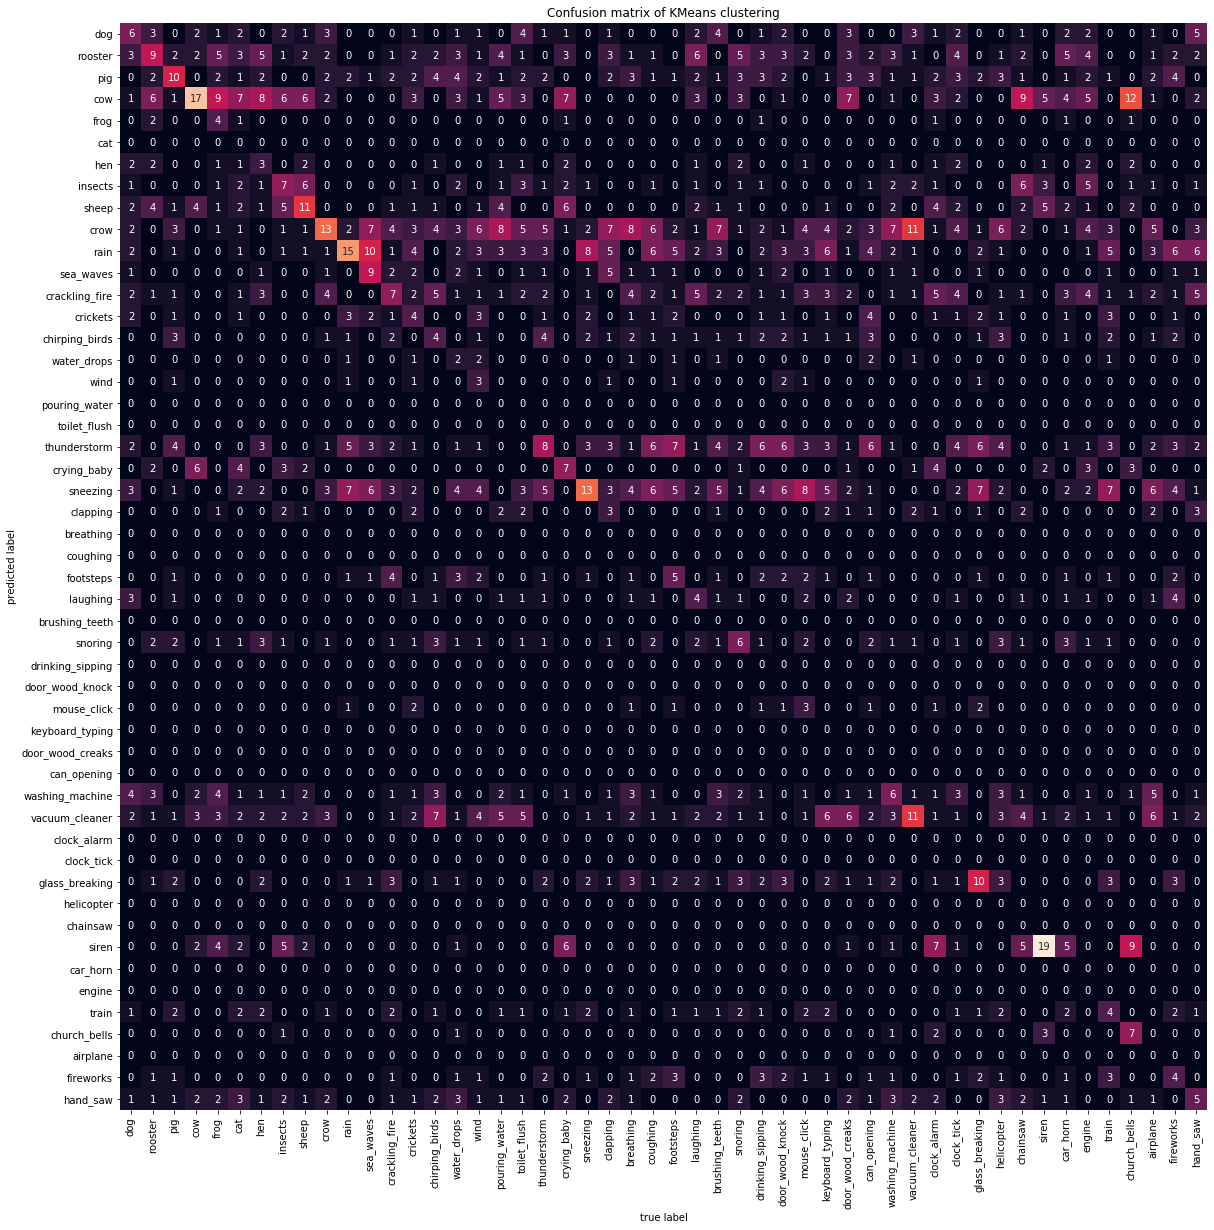

In [26]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (20,20))
mat = confusion_matrix(target, kmeans_2_labels)
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=target_names_list,yticklabels=target_names_list)
plt.xlabel('true label')
plt.title('Confusion matrix of KMeans clustering')
plt.ylabel('predicted label')
plt.show()

Now I will use all the features, and use KMeans again.

accuracy of kmeans model:  0.17


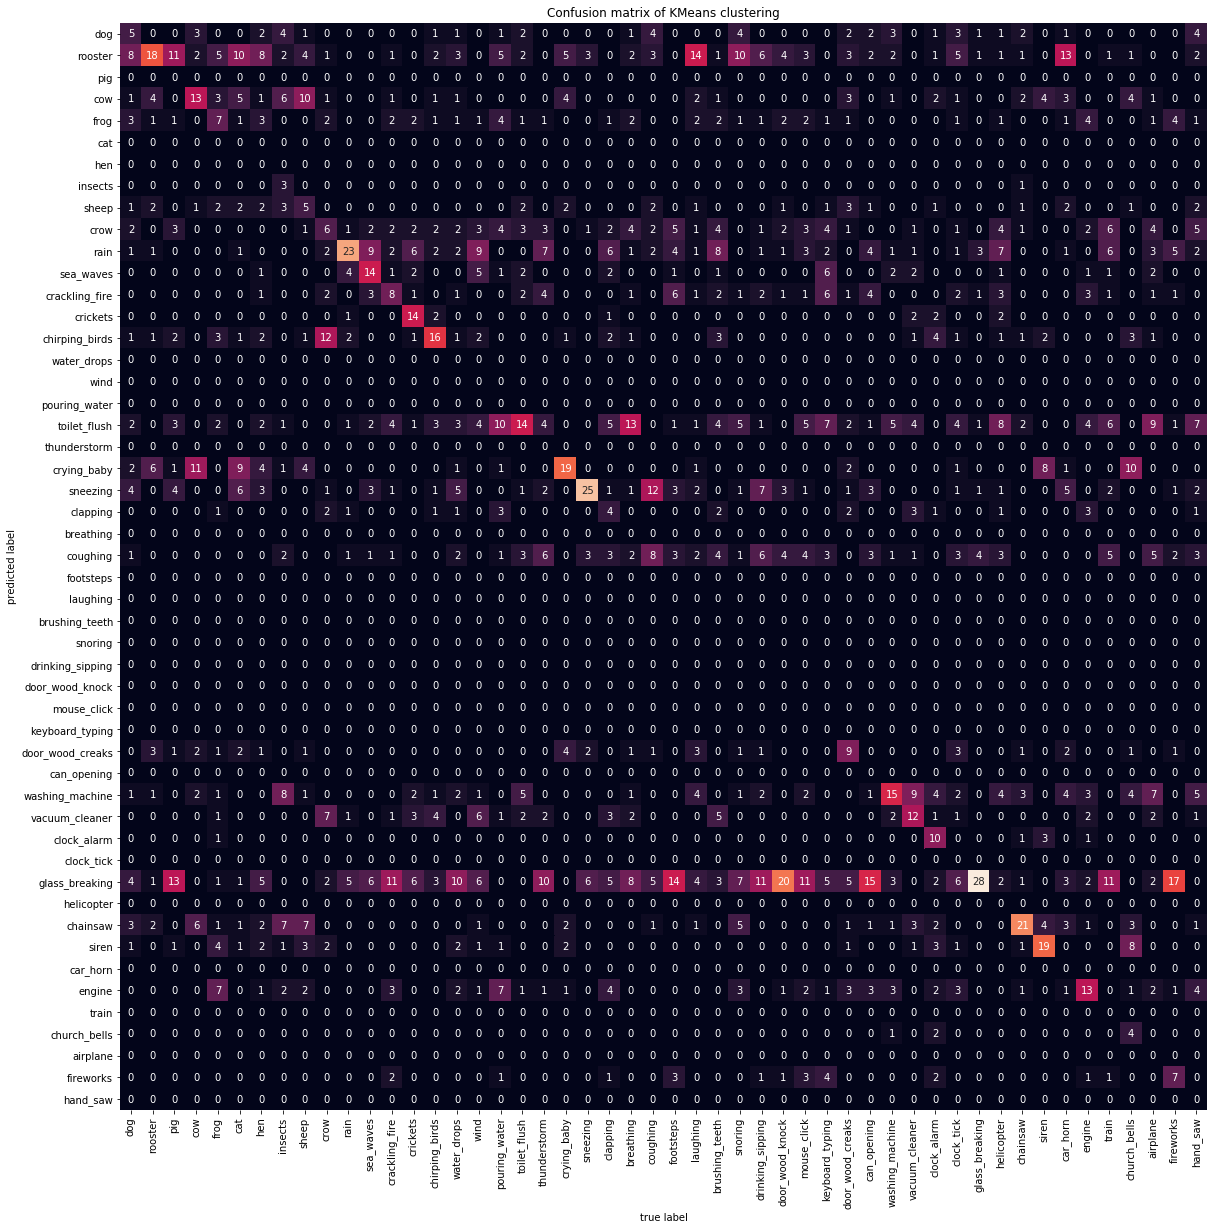

In [27]:
kmeans = KMeans(n_clusters=50)
kmeans_cluster = kmeans.fit_predict(esc50.iloc[:,3:])

target=np.asarray(esc50['target'])
kmeans_labels = np.zeros_like(kmeans_cluster)

for i in range(50):
    mask = (kmeans_cluster == i)
    kmeans_labels[mask] = mode(target[mask])[0]
    
print('accuracy of kmeans model: ',accuracy_score(target, kmeans_labels))

plt.figure(figsize = (20,20))
mat = confusion_matrix(target, kmeans_labels)
ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=target_names_list,yticklabels=target_names_list)
plt.xlabel('true label')
plt.title('Confusion matrix of KMeans clustering')
plt.ylabel('predicted label')
plt.show()

I get a better performence using more features when I use KMeans to cluter esc50 data.
Next, I will try SVM. First I will split the data into training and test data.

In [28]:
# split the data

x = esc50[['E_max','E_min','E_mean',
            's_tract_max','s_tract_min','s_tract_mean',
            'f_tract_max','f_tract_min','f_tract_mean',
            's_tract_hist','f_tract_hist']]  # data
n_features = x.shape[1]
y = esc50['target']  # label
target_names=esc50['category']
n_classes = target_names.shape[0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # split 30% as test data

In [29]:
# make four SVM models
model_00_1 = SVC(kernel='linear', C=0.01)
model_00_1.fit(x_train, y_train)
model_100 = SVC(kernel='linear', C=100)
model_100.fit(x_train, y_train)
model_rbf = SVC(kernel='rbf',gamma ='auto')
model_rbf.fit(x_train, y_train)
model_poly = SVC(kernel='poly',gamma ='auto')
model_poly.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
y_pred_100 = model_100.predict(x_test)
y_pred_00_1 = model_00_1.predict(x_test)
y_pred_rbf = model_rbf.predict(x_test)
y_pred_poly = model_poly.predict(x_test)

In [31]:
print("Accuracy of model c=100:",metrics.accuracy_score(y_test, y_pred_100))
print("Accuracy of model c=0.01:",metrics.accuracy_score(y_test, y_pred_00_1))
print("Accuracy of model rbf kernel:",metrics.accuracy_score(y_test, y_pred_rbf))
print("Accuracy of model poly kernel:",metrics.accuracy_score(y_test, y_pred_poly))

Accuracy of model c=100: 0.16833333333333333
Accuracy of model c=0.01: 0.023333333333333334
Accuracy of model rbf kernel: 0.043333333333333335
Accuracy of model poly kernel: 0.025


The result of accuracy is not good (although better than a blind guess which is 2%), so I should get some new features, and I think **frequency features** are some good features, because it don't contain time information.
I am going to use **proportion** of high vs mid+low frequency or low vs hign+mid frequency.

In [32]:
#########   build high vs 0.5*(mid+low) frequency features
#########   build mid vs 0.5*(high+low) frequency features
#########   build low vs 0.5*(mid+high) frequency features

#### for E features  ####

#  E Low_frequency feature
def E_L_f(filename):    
    sum_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    E = np.asarray(file['E'])
    E = np.log(E)
    
    #delete some noises
    E=np.where(E>np.percentile(E,noise_cancel),np.percentile(E,noise_cancel),E)
    m = E.shape[0]         #100

    return np.sum(E[0:33,:])/(0.5*np.sum(E[33:m,:]))  # Low frequency part / 0.5*(High frequency + Mid frequency)


#  E Middle_frequency feature
def E_M_f(filename):    
    sum_list=[]
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    E = np.asarray(file['E'])
    E = np.log(E)
    #delete some noises
    E=np.where(E>np.percentile(E,noise_cancel),np.percentile(E,noise_cancel),E)
    m = E.shape[0]         #100
    return np.sum(E[33:66,:])/(np.sum(E[0:33,:])+np.sum(E[66:m,:]))


#  E High_frequency feature
def E_H_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    E = np.asarray(file['E'])
    E = np.log(E)
    #delete some noises
    E=np.where(E>np.percentile(E,noise_cancel),np.percentile(E,noise_cancel),E)
    m = E.shape[0]         #100
    return np.sum(E[66:m,:])/(0.5*np.sum(E[0:66,:]))


#### for s_tract  ####

#  S_tract Low_frequency feature
def s_tract_L_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    s_tract = np.asarray(file['s_tract'])# save as np array
    #  delete first and last 6 rows
    s_tract=np.delete(s_tract, np.s_[0:6:1], 0)
    s_tract=np.delete(s_tract, np.s_[88:94:1], 0)  ##  88 rows now
    #delete some noises
    s_tract=np.where(s_tract>np.percentile(s_tract,noise_cancel),np.percentile(s_tract,noise_cancel),s_tract)
    m = s_tract.shape[0]   #88
    return np.sum(s_tract[0:29,:])/(0.5*np.sum(s_tract[29:m,:]))


#  s_tract Middle_frequency feature
def s_tract_M_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    s_tract = np.asarray(file['s_tract'])# save as np array
    #  delete first and last 6 rows
    s_tract=np.delete(s_tract, np.s_[0:6:1], 0)
    s_tract=np.delete(s_tract, np.s_[88:94:1], 0)  ##  88 rows now
    #delete some noises
    s_tract=np.where(s_tract>np.percentile(s_tract,noise_cancel),np.percentile(s_tract,noise_cancel),s_tract)
    m = s_tract.shape[0]   #88
    return np.sum(s_tract[29:58,:])/(np.sum(s_tract[0:29,:])+np.sum(s_tract[58:m,:]))



#  S_tract High_frequency feature
def s_tract_H_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    s_tract = np.asarray(file['s_tract'])# save as np array 
    #  delete first and last 6 rows
    s_tract=np.delete(s_tract, np.s_[0:6:1], 0)
    s_tract=np.delete(s_tract, np.s_[88:94:1], 0)  ##  88 rows now
    #delete some noises
    s_tract=np.where(s_tract>np.percentile(s_tract,noise_cancel),np.percentile(s_tract,noise_cancel),s_tract)
    m = s_tract.shape[0]   #88
    return np.sum(s_tract[58:m,:])/(0.5*np.sum(s_tract[0:58,:]))


#### for f_tract  ####

#  F_tract Low_frequency feature
def f_tract_L_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    f_tract = np.asarray(file['f_tract'])# save as np array
    #  delete first and last 6 rows
    f_tract=np.delete(f_tract, np.s_[0:6:1], 0)
    f_tract=np.delete(f_tract, np.s_[88:94:1], 0)  ##  88 rows now
    #delete some noises
    f_tract=np.where(f_tract>np.percentile(f_tract,noise_cancel),np.percentile(f_tract,noise_cancel),f_tract)
    m = f_tract.shape[0]   #88
    return np.sum(f_tract[0:29,:])/(0.5*np.sum(f_tract[29:m,:]))


#  f_tract Middle_frequency feature
def f_tract_M_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    f_tract = np.asarray(file['f_tract'])# save as np array
    #  delete first and last 6 rows
    f_tract=np.delete(f_tract, np.s_[0:6:1], 0)
    f_tract=np.delete(f_tract, np.s_[88:94:1], 0)  ##  88 rows now
    #delete some noises
    f_tract=np.where(f_tract>np.percentile(f_tract,noise_cancel),np.percentile(f_tract,noise_cancel),f_tract)
    m = f_tract.shape[0]   #88
    return np.sum(f_tract[29:58,:])/(np.sum(f_tract[0:29,:])+np.sum(f_tract[58:m,:]))



#  f_tract High_frequency feature
def f_tract_H_f(filename):    
    noise_cancel=90
    hdf5_file='/home/meitao/Desktop/AML_files/ESC-50-Processed/tracts/hdf5/2019-10-31/' + filename + '.1.hdf5'
    file=h5py.File(hdf5_file,'r')
    f_tract = np.asarray(file['f_tract'])# save as np array
    #  delete first and last 6 rows
    f_tract=np.delete(f_tract, np.s_[0:6:1], 0)
    f_tract=np.delete(f_tract, np.s_[88:94:1], 0)  ##  88 rows now
    #delete some noises
    f_tract=np.where(f_tract>np.percentile(f_tract,noise_cancel),np.percentile(f_tract,noise_cancel),f_tract)
    m = f_tract.shape[0]   #88
    return np.sum(f_tract[58:m,:])/(0.5*np.sum(f_tract[0:58,:]))

In [33]:
# make empty list to store features
E_H_f_list = []
E_M_f_list = []
E_L_f_list = []

s_tract_H_f_list = []
s_tract_M_f_list = []
s_tract_L_f_list = []

f_tract_H_f_list = []
f_tract_M_f_list = []
f_tract_L_f_list = []

In [34]:
# get features for 2000 files
for file in filelist:
    E_H_f_list.append(E_H_f(file))
    E_M_f_list.append(E_M_f(file))
    E_L_f_list.append(E_L_f(file))

    s_tract_H_f_list.append(s_tract_H_f(file))
    s_tract_M_f_list.append(s_tract_M_f(file))
    s_tract_L_f_list.append(s_tract_L_f(file))

    f_tract_H_f_list.append(f_tract_H_f(file))
    f_tract_M_f_list.append(f_tract_M_f(file))
    f_tract_L_f_list.append(f_tract_L_f(file))
    

In [35]:
# put features into the pandas dataframe
esc50['E_H_f'] = E_H_f_list
esc50['E_M_f'] = E_M_f_list
esc50['E_L_f'] = E_L_f_list

esc50['s_H_f'] = s_tract_H_f_list
esc50['s_M_f'] = s_tract_M_f_list
esc50['s_L_f'] = s_tract_L_f_list

esc50['f_H_f'] = f_tract_H_f_list
esc50['f_M_f'] = f_tract_M_f_list
esc50['f_L_f'] = f_tract_L_f_list

# Scale all the features from 0 to 1
esc50['E_H_f']=scaler.fit_transform(np.asarray(esc50['E_H_f']).reshape(-1, 1))
esc50['E_M_f']=scaler.fit_transform(np.asarray(esc50['E_M_f']).reshape(-1, 1))
esc50['E_L_f']=scaler.fit_transform(np.asarray(esc50['E_L_f']).reshape(-1, 1))

esc50['s_H_f']=scaler.fit_transform(np.asarray(esc50['s_H_f']).reshape(-1, 1))
esc50['s_M_f']=scaler.fit_transform(np.asarray(esc50['s_M_f']).reshape(-1, 1))
esc50['s_L_f']=scaler.fit_transform(np.asarray(esc50['s_L_f']).reshape(-1, 1))

esc50['f_H_f']=scaler.fit_transform(np.asarray(esc50['f_H_f']).reshape(-1, 1))
esc50['f_M_f']=scaler.fit_transform(np.asarray(esc50['f_M_f']).reshape(-1, 1))
esc50['f_L_f']=scaler.fit_transform(np.asarray(esc50['f_L_f']).reshape(-1, 1))

In [105]:
# make sure I get the right features: each file has 20 features and the feature value from 0 to 1
esc50.describe()

,target,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean,...,f_tract_hist,E_H_f,E_M_f,E_L_f,s_H_f,s_M_f,s_L_f,f_H_f,f_M_f,f_L_f
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,24.500000,0.913054,0.913054,0.913054,0.785858,0.785858,0.785858,0.633007,0.633007,0.633007,...,0.424409,0.099309,0.503075,0.582026,0.225399,0.392712,0.436297,0.305010,0.491271,0.318565
std,14.434479,0.085893,0.085893,0.085893,0.085413,0.085413,0.085413,0.093933,0.093933,0.093933,...,0.150116,0.064968,0.074720,0.150862,0.046388,0.064953,0.079603,0.055880,0.067449,0.064926
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.886565,0.886565,0.886565,0.760256,0.760256,0.760256,0.574769,0.574769,0.574769,...,0.319101,0.065988,0.461226,0.507374,0.211761,0.365827,0.403797,0.288799,0.471557,0.292542
50%,24.500000,0.934309,0.934309,0.934309,0.793329,0.793329,0.793329,0.623960,0.623960,0.623960,...,0.423522,0.084591,0.493622,0.601387,0.229591,0.387917,0.426640,0.301990,0.499035,0.311784
75%,37.000000,0.965322,0.965322,0.965322,0.829702,0.829702,0.829702,0.686060,0.686060,0.686060,...,0.527306,0.109585,0.537382,0.681385,0.241978,0.411967,0.456814,0.316901,0.520044,0.334991
max,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot new features comparison

Text(0, 0.5, 's_tract_Low_frequency Vs others')

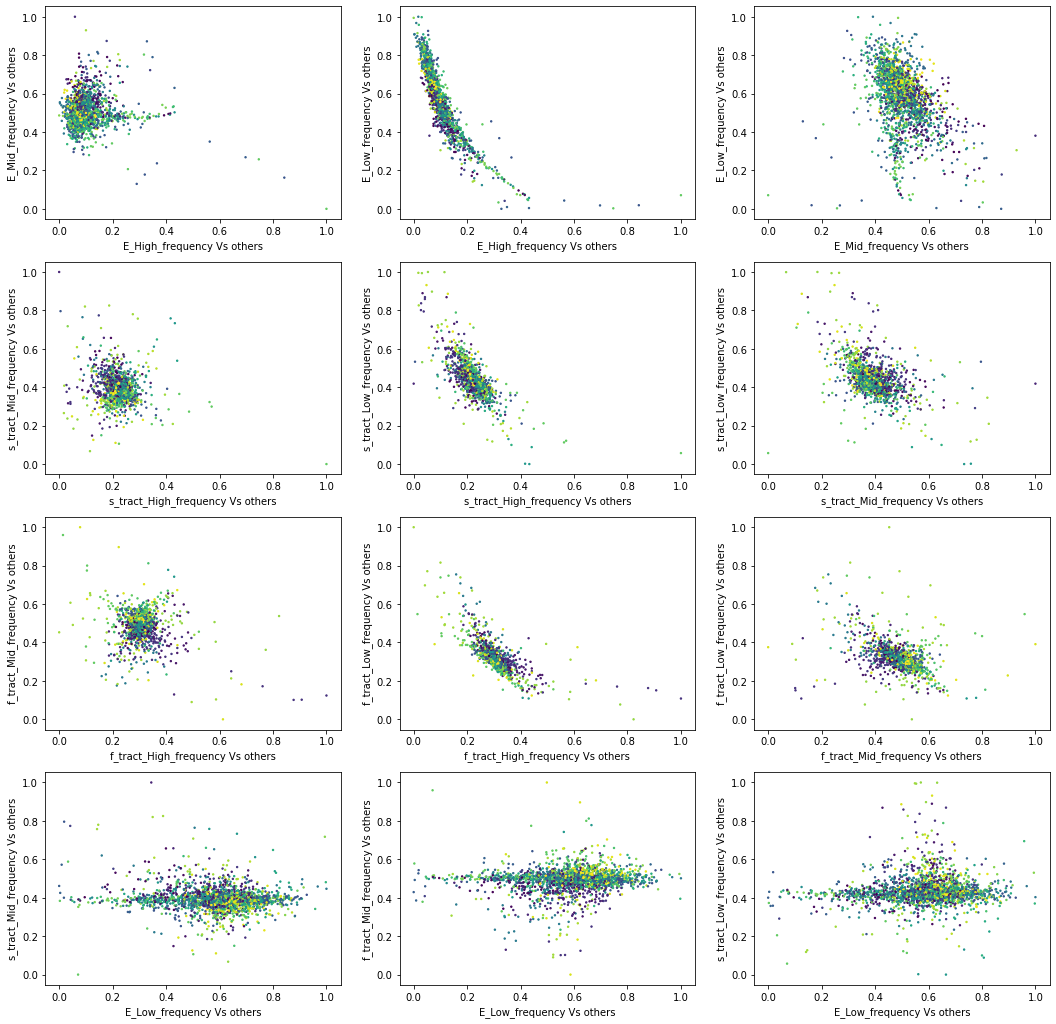

In [37]:
color = np.asarray(esc50['target'])

fig = plt.figure(figsize=(18, 18))
#########   E   ###########
plt.subplot(4,3,1)
plt.scatter(esc50['E_H_f'],esc50['E_M_f'],s=2,c=color)
plt.xlabel('E_High_frequency Vs others')
plt.ylabel('E_Mid_frequency Vs others')

plt.subplot(4,3,2)
plt.scatter(esc50['E_H_f'],esc50['E_L_f'],s=2,c=color)
plt.xlabel('E_High_frequency Vs others')
plt.ylabel('E_Low_frequency Vs others')

plt.subplot(4,3,3)
plt.scatter(esc50['E_M_f'],esc50['E_L_f'],s=2,c=color)
plt.xlabel('E_Mid_frequency Vs others')
plt.ylabel('E_Low_frequency Vs others')

#  s_tract
plt.subplot(4,3,4)
plt.scatter(esc50['s_H_f'],esc50['s_M_f'],s=2,c=color)
plt.xlabel('s_tract_High_frequency Vs others')
plt.ylabel('s_tract_Mid_frequency Vs others')

plt.subplot(4,3,5)
plt.scatter(esc50['s_H_f'],esc50['s_L_f'],s=2,c=color)
plt.xlabel('s_tract_High_frequency Vs others')
plt.ylabel('s_tract_Low_frequency Vs others')

plt.subplot(4,3,6)
plt.scatter(esc50['s_M_f'],esc50['s_L_f'],s=2,c=color)
plt.xlabel('s_tract_Mid_frequency Vs others')
plt.ylabel('s_tract_Low_frequency Vs others')

#  f_tract
plt.subplot(4,3,7)
plt.scatter(esc50['f_H_f'],esc50['f_M_f'],s=2,c=color)
plt.xlabel('f_tract_High_frequency Vs others')
plt.ylabel('f_tract_Mid_frequency Vs others')

plt.subplot(4,3,8)
plt.scatter(esc50['f_H_f'],esc50['f_L_f'],s=2,c=color)
plt.xlabel('f_tract_High_frequency Vs others')
plt.ylabel('f_tract_Low_frequency Vs others')

plt.subplot(4,3,9)
plt.scatter(esc50['f_M_f'],esc50['f_L_f'],s=2,c=color)
plt.xlabel('f_tract_Mid_frequency Vs others')
plt.ylabel('f_tract_Low_frequency Vs others')

# 
plt.subplot(4,3,10)
plt.scatter(esc50['E_L_f'],esc50['s_M_f'],s=2,c=color)
plt.xlabel('E_Low_frequency Vs others')
plt.ylabel('s_tract_Mid_frequency Vs others')

plt.subplot(4,3,11)
plt.scatter(esc50['E_L_f'],esc50['f_M_f'],s=2,c=color)
plt.xlabel('E_Low_frequency Vs others')
plt.ylabel('f_tract_Mid_frequency Vs others')

plt.subplot(4,3,12)
plt.scatter(esc50['E_L_f'],esc50['s_L_f'],s=2,c=color)
plt.xlabel('E_Low_frequency Vs others')
plt.ylabel('s_tract_Low_frequency Vs others')

* The first row of the plot shows the comparision between high and mid and low frequency features for Edb files
* The second row of the plot shows the comparision between high and mid and low frequency features for s_tract files
* The third row of the plot shows the comparision between high and mid and low frequency features for f_tract files
* The fourth row of the plot shows some features comparision which I expect to have a nice distubution.

In [38]:
esc50.head()

,filename,target,category,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,...,f_tract_hist,E_H_f,E_M_f,E_L_f,s_H_f,s_M_f,s_L_f,f_H_f,f_M_f,f_L_f
0,1-100032-A-0.wav,0,dog,0.998040,0.998040,0.998040,0.786261,0.786261,0.786261,0.531680,...,0.552033,0.408976,0.493921,0.078315,0.234362,0.385285,0.423515,0.301495,0.504061,0.309291
1,1-100038-A-14.wav,14,chirping_birds,0.658051,0.658051,0.658051,0.836568,0.836568,0.836568,0.556183,...,0.270189,0.146185,0.597500,0.371491,0.258752,0.348272,0.417616,0.297097,0.573924,0.279507
2,1-100210-A-36.wav,36,vacuum_cleaner,0.865889,0.865889,0.865889,0.776946,0.776946,0.776946,0.615503,...,0.409536,0.080390,0.488588,0.625670,0.219390,0.392673,0.440098,0.302068,0.491724,0.315117
3,1-100210-B-36.wav,36,vacuum_cleaner,0.870982,0.870982,0.870982,0.841562,0.841562,0.841562,0.579919,...,0.367202,0.079965,0.485894,0.629332,0.220246,0.421365,0.416379,0.296355,0.485470,0.324630
4,1-101296-A-19.wav,19,thunderstorm,0.899215,0.899215,0.899215,0.791538,0.791538,0.791538,0.585992,...,0.423522,0.045721,0.473392,0.771810,0.222808,0.390962,0.436275,0.289647,0.565842,0.291070


In [39]:
esc50.describe()

,target,E_max,E_min,E_mean,s_tract_max,s_tract_min,s_tract_mean,f_tract_max,f_tract_min,f_tract_mean,...,f_tract_hist,E_H_f,E_M_f,E_L_f,s_H_f,s_M_f,s_L_f,f_H_f,f_M_f,f_L_f
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,24.500000,0.913054,0.913054,0.913054,0.785858,0.785858,0.785858,0.633007,0.633007,0.633007,...,0.424409,0.099309,0.503075,0.582026,0.225399,0.392712,0.436297,0.305010,0.491271,0.318565
std,14.434479,0.085893,0.085893,0.085893,0.085413,0.085413,0.085413,0.093933,0.093933,0.093933,...,0.150116,0.064968,0.074720,0.150862,0.046388,0.064953,0.079603,0.055880,0.067449,0.064926
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.886565,0.886565,0.886565,0.760256,0.760256,0.760256,0.574769,0.574769,0.574769,...,0.319101,0.065988,0.461226,0.507374,0.211761,0.365827,0.403797,0.288799,0.471557,0.292542
50%,24.500000,0.934309,0.934309,0.934309,0.793329,0.793329,0.793329,0.623960,0.623960,0.623960,...,0.423522,0.084591,0.493622,0.601387,0.229591,0.387917,0.426640,0.301990,0.499035,0.311784
75%,37.000000,0.965322,0.965322,0.965322,0.829702,0.829702,0.829702,0.686060,0.686060,0.686060,...,0.527306,0.109585,0.537382,0.681385,0.241978,0.411967,0.456814,0.316901,0.520044,0.334991
max,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
esc50.std()

target          14.434479
E_max            0.085893
E_min            0.085893
E_mean           0.085893
s_tract_max      0.085413
s_tract_min      0.085413
s_tract_mean     0.085413
f_tract_max      0.093933
f_tract_min      0.093933
f_tract_mean     0.093933
s_tract_hist     0.188313
f_tract_hist     0.150116
E_H_f            0.064968
E_M_f            0.074720
E_L_f            0.150862
s_H_f            0.046388
s_M_f            0.064953
s_L_f            0.079603
f_H_f            0.055880
f_M_f            0.067449
f_L_f            0.064926
dtype: float64

I choose three features whose standard deviation is larger than 0.1, and see the classfify results.

In [96]:
X=esc50[['s_tract_hist','f_tract_hist','E_L_f']]
y=esc50.iloc[:,1]

In [97]:
# shuffle the data
seed = 20
X, y = shuffle(X,y,random_state=seed)
# split 20% as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split 20% as test data

Another dataset with all 20 features

In [98]:
# X_whole will use all the features
X_whole = esc50.iloc[:,3:23]
y_whole = esc50.iloc[:,1]
# shuffle the data 
seed = 23
X_whole, y_whole = shuffle(X_whole,y_whole,random_state=seed)

In [99]:
# Split 20% of whole data as test data
X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole, y_whole, test_size=0.2) # split 20% as test data

### How does performance of the classifiers built depend on the machine learning algorithm and their parameters?
### How does performance of the classifiers built depend on feature extraction parameters?

Now I have two dataset, one is a dataset only with two features, another one is with all 20 features I extracted from Edb and tract files.
I will compare the performence between two dataset below.
I will alos use the GridSearchCV from sklearn to do "grid-search" to obtain the optimal parameters of my SVM model. And "GridSearchCV" has cross_validation funtion, I don't need to spilit data to training and validation data.

In [100]:
kernels = ['linear','rbf','poly']
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'kernel':kernels, 'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(probability=True),param_grid, cv=10, n_jobs=-1)  # cross validation = 10 folders
grid_search.fit(X_train, y_train)
print('best paremeters are: ',grid_search.best_params_)
print('best score is: ',grid_search.best_score_)

/home/meitao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best paremeters are:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
best score is:  0.1275


We can tell that using SVC with 'poly' kernel, C=100, gamma=1 is the best model, and let's use test_data to test the model. 

In [101]:
svc_best_= svm.SVC(kernel='rbf', C=100,gamma=1, probability=True)
svc_best.fit(X_train,y_train)
metrics.accuracy_score(y_test, svc_best.predict(X_test))

0.12

This model (with 'C': 100, 'gamma': 1, 'kernel': 'rbf') and using two features('s_tract_hist','f_tract_hist','E_L_f') gives a accuracy of 12%.

Next I will try to use all the features instead of only three features. 

In [102]:
kernels = ['linear','rbf','poly']
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'kernel':kernels, 'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(probability=True),param_grid, cv=10, n_jobs=-1)  # cross validation = 10 folders
grid_search.fit(X_whole_train, y_whole_train)
print('best paremeters are: ',grid_search.best_params_)
print('best score is: ',grid_search.best_score_)

/home/meitao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best paremeters are:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
best score is:  0.359375


In [103]:
svc_best= svm.SVC(kernel='rbf',C=100,gamma=1)
svc_best.fit(X_whole_train,y_whole_train)
metrics.accuracy_score(y_whole_test, svc_best.predict(X_whole_test))

0.33

Using all 20 features and same model('C': 100, 'gamma': 1, 'kernel': 'rbf') increases the accuracy to 33%.